
# **Non-intrusive reduced order models for partitioned fluid-structure interactions**

A. Tiba, T. Dairay, F. De Vuyst, I. Mortazavi, J-P. Berro Ramirez

## Installation

In [1]:
if 'google.colab' in str(get_ipython()): # Colab env
  inColab = True
else: # Local env
  inColab = False

if inColab:
  !git clone https://github.com/FsiROM/SIMWorkshop
  %cd SIMWorkshop/
!sh install.sh

# ============ installing pyvista
if inColab:
  !wget "https://fem-on-colab.github.io/releases/vtk-install.sh" -O "/tmp/vtk-install.sh" > /dev/null 2>&1 && bash "/tmp/vtk-install.sh" > /dev/null 2>&1
else:
  !pip install pyvista


Cloning into 'SIMWorkshop'...
remote: Enumerating objects: 2424, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 2424 (delta 23), reused 27 (delta 6), pack-reused 2356
Receiving objects: 100% (2424/2424), 37.16 MiB | 34.87 MiB/s, done.
Resolving deltas: 100% (2122/2122), done.
/content/SIMWorkshop

============= Installing KratosMultiphysics and necessary applications

============= Installing KratosMultiphysics extension for ROM-FOM simulations (See https://github.com/FsiROM/Kratos )

============= Installing ROM_AM package for non intrusive model reduction (See https://github.com/azzeddinetiba/ROM_AM )


In [2]:
import panel
import pyvista
panel.extension("vtk")
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import rom_am
from rom_am.solid_rom import solid_ROM

## The ROM-FOM Approach

A general FSI problem involving an incompressible fluid flow under an ALE description, and an hyperelastic solid can be described by the following equations for each subproblem.
For the fluid subproblem, the incompressible Navier-Stokes in the ALE frame are written as:
\begin{equation}
\begin{cases}
        \rho_f \dfrac{\partial \pmb{v}}{\partial t}_{|\tilde{\mathcal{A}}} + \rho_f [(\pmb{v} - \pmb{w}).\nabla]\pmb{v} + \nabla p - 2 \,\pmb{\text{div}}(\mu_f \pmb{D}(\pmb{v})) = 0 \quad \text{in}\ \Omega_f(t)\\[1.3ex]
        \nabla\cdot\pmb{v}= 0 \quad \text{in }\ \Omega_f(t)\\[1.3ex]
        (2 \mu_f \pmb{D}(\pmb{v}) - p \pmb{I} )\, \pmb{n}_f = \pmb{g}_{N, f}\ \text{in}\ \Gamma_{N, f}(t)\\
\end{cases}    
\end{equation}

along with no-slip boundary conditions at walls, imposed velocity profile at the inflow boundaries, and imposed pressure at the outflow boundaries.

For the solid subproblem, the equilibrium and constitutive equations for a static hyperelastic solid are:
        \begin{equation}
        \begin{cases}
             \nabla_{\pmb{X}} \pmb{P} = \pmb{0} \quad \text{in}\; \Omega_{s} \\[1.3ex]
            \pmb{P} = \dfrac{\partial W}{\partial \pmb{F}} \\[1.3ex]
            \pmb{u} = \pmb{0} \; \quad \text{in}\; \Gamma_{D, s}\\[1.3ex]
            \pmb{P} \cdot \pmb{N}_s = \pmb{G}_{N, s}\; \quad \text{in}\; \Gamma_{N, s}\\
        \end{cases}  
        \end{equation}

And finally, the FSI coupling conditions are:
    \begin{equation}
            \begin{cases}
        \pmb{v} = \dfrac{\partial \pmb{u}}{\partial t} = \pmb{w} \quad \text{on}\ \Gamma_{fsi}(t)\\[1.3ex]
        J^{-1} \pmb{F}^T_s \pmb{P} \cdot \pmb{n}_s + (2 \mu_f\, \pmb{D}(\pmb{v}) - p \,\pmb{I} ) \cdot \pmb{n}_f = \pmb{0} \quad \text{on}\ \Gamma_{fsi}(t)\\
        \end{cases}
    \end{equation}


with $\rho_f$ the fluid density, $\mu_f$ the fluid dynamic viscosity, $\pmb{v}$ is the Eulerian fluid velocity and $\pmb{D}(\pmb{v})$ is the fluid strain rate tensor. The fluid equations are described on a moving domain (using the ALE moving frame) $\Omega_f(t)$. The Neumann boundary conditions are defined on the moving boundary $\Gamma_{N, f}(t)$ where $\pmb{n}_f$ represents its exterior normal unit vector.

For the solid problem, the equations are written in the Lagrangian frame with $\nabla_{\pmb{X}}$ the gradient operator in the original configuration, $\pmb{F}_s$ the deformation gradient and $J$ its determinant. $\pmb{P}$ is the first Piola-Kirchoff stress tensor and $\Gamma_{D, s}$ and $\Gamma_{N, s}$ are the Dirichlet and Neumann boundaries respectively, in the original configuration as well, whereas $\pmb{n}_s$ is the normal vector in the \textit{current} configuration.  The vector field $\pmb{u}$ is the solid displacement field and $\pmb{G}_{N, s}$ is the traction force in the original configuration. The material model is described in the stored energy density function~$W$.

---


In the context of partitioned FSI simulations, we will use the $Dirichlet-Neumann$ coupling formulation that allows a 'black-box' FSI coupling. We represent the fluid solver operation as $\mathcal{F}$ :

\begin{equation}
  \mathcal{F} : \mathbb{R}^N \rightarrow \mathbb{R}^N\;;\; \pmb{u}_{|\Gamma_{fsi}} \rightarrow \pmb{f}_{|\Gamma_{fsi}}
\end{equation}

where $\pmb{u}_{|\Gamma_{fsi}}$ is the displacement field and $\pmb{f}_{|\Gamma_{fsi}}$ represents the fluid viscous and pressure forces at $\Gamma_{fsi}$:
\begin{equation}
  \pmb{f}_{|\Gamma_{fsi}} = (2 \mu_f  \pmb{D}(\nabla\pmb{v}) - p \pmb{I} ) \cdot \pmb{n}_{f|\Gamma_{fsi}}.
\end{equation}

Similarly, the solid operator is defined as:
\begin{equation}
  \mathcal{S} : \mathbb{R}^N \rightarrow \mathbb{R}^N\;;\; \pmb{f}_{|\Gamma_{fsi}} \rightarrow \pmb{u}_{|\Gamma_{fsi}}  .
\end{equation}

In fully implicit schemes, the coupling conditions can be enforced  using a fixed-point formulation of the FSI problem:
\begin{equation}
    (\mathcal{F} \circ \mathcal{S})(\pmb{f}_{|\Gamma_{fsi}}) = \pmb{f}_{|\Gamma_{fsi}}.
\end{equation}

One approach to solve this problem  at each time step is to compute Picard iterations plus a fixed-point acceleration using Quasi-Newton methods for the FSI problem:

\begin{equation}
    (\mathcal{F} \circ \mathcal{S})(\pmb{f}_{|\Gamma_{fsi}}) - \pmb{f}_{|\Gamma_{fsi}} = \pmb{0}
\end{equation}



---



The goal of the ROMs used in this work is to reduce the overall computational cost of the FSI problem through the order reduction of the solid subproblem only. Using partitioned FSI schemes allows for the replacement of the "*module*" of the solid solver $\mathcal{S}$ with a new ROM solver $\mathcal{S}^{'}$:
\begin{equation}
  \mathcal{S}^{'}: \mathbb{R}^N \rightarrow \mathbb{R}^N\;;\; \pmb{f}_{|\Gamma_{fsi}} \rightarrow \hat{\pmb{u}}_{|\Gamma_{fsi}}
\end{equation}
and thus achieving a non-intrusive implementation of the model reduction.



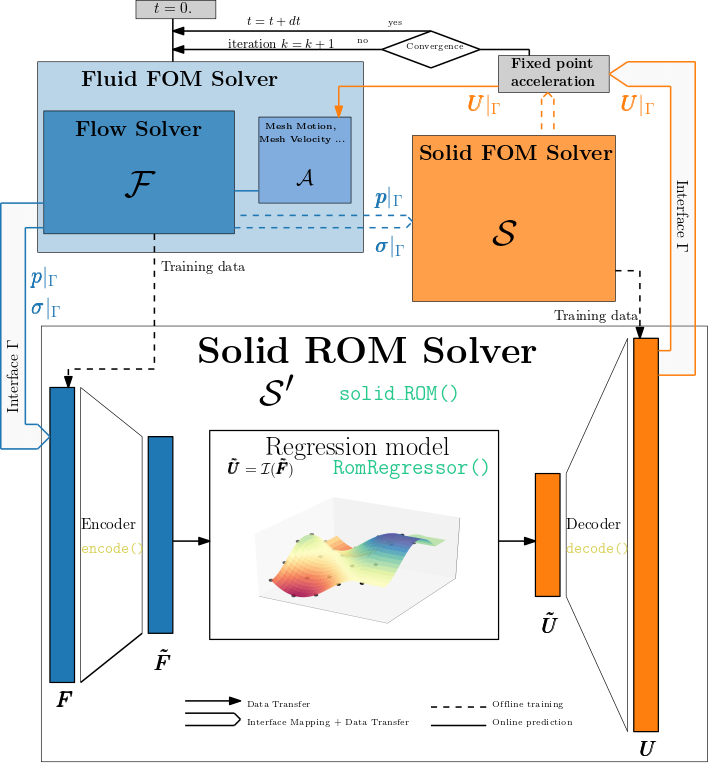



---



## Our test case

It consists in a 2D convergent fluid channel that contains a flexible wall structure attached to its bottom wall. [[1, 2]](#References)

The wall is modeled using a hyperelastic Neo-Hookean model, with the strain energy expressed as:

> $W(\pmb{F}_s) = \frac{\mu_s}{2}\, (|\pmb{F}_s|^2 - 3 - 2\, \log(J))$

where we define $\mu_s = \dfrac{E}{2 (1 + \nu_s)}$ and we choose $E = 2.8 \times 10^9$Pa and $\nu_s = 0.45$


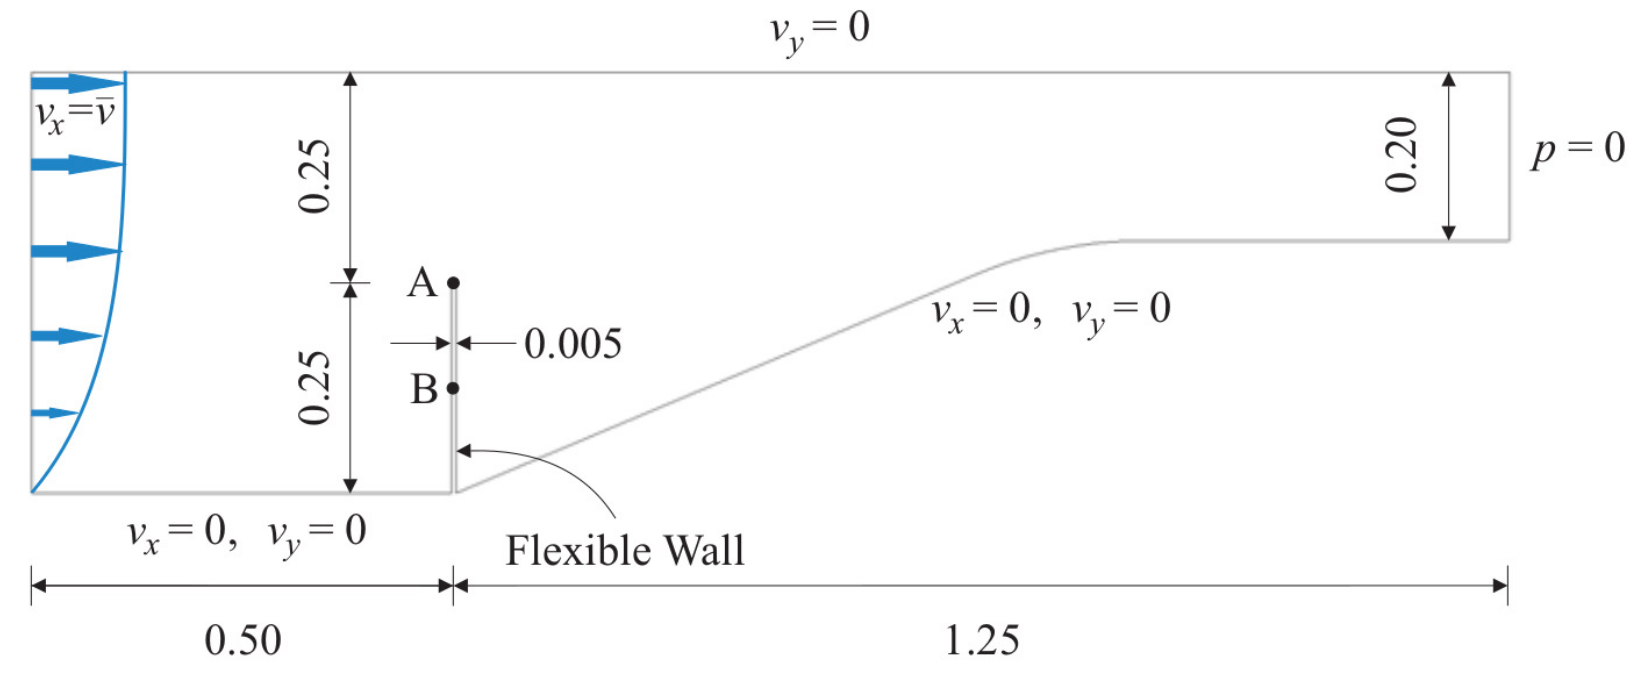

**The inflow:**
A parabolic profile is imposed

$v(y, t) = 8 \bar{v}(t) y (1-y)$

where
$    \begin{cases}
	 \bar{v}(t) = (1-cos(\pi t/10)) ,
	\quad \ t\in [0  , 10 s] \\
        \bar{v}(t) =  0.2 ( (cos(\pi  f_1  (t-10.))) +  (cos(f_2 \pi (t-10.))) ) + 1.6,
	\quad \ t\in [10 s , 25 s]
 \end{cases}$

 with $f_1 = 0.2 Hz$



**The simulation**

The structural problem is discretized using 4-noded quadrilateral elements with a total of 303 vertices.

The fluid problem is also simulated using finite elements and the variational multiscale scheme [[4]](#References) with a coarse mesh of triangular elements totaling 298 vertices.

The FSI coupled problem is coupled through a partitioned approach using [`KratosMultiphysics`](https://github/FsiROM/KratosMultiphysics). The FSI acceleration used here is the MVQN (Multi-Vector update Quasi-Newton) [[5]]((#References)


Simulation results are available for $f_2 \in \{ 0.1, 0.5, 0.9 \}$.
An example of the flow at $f_1 = 0.5 Hz$

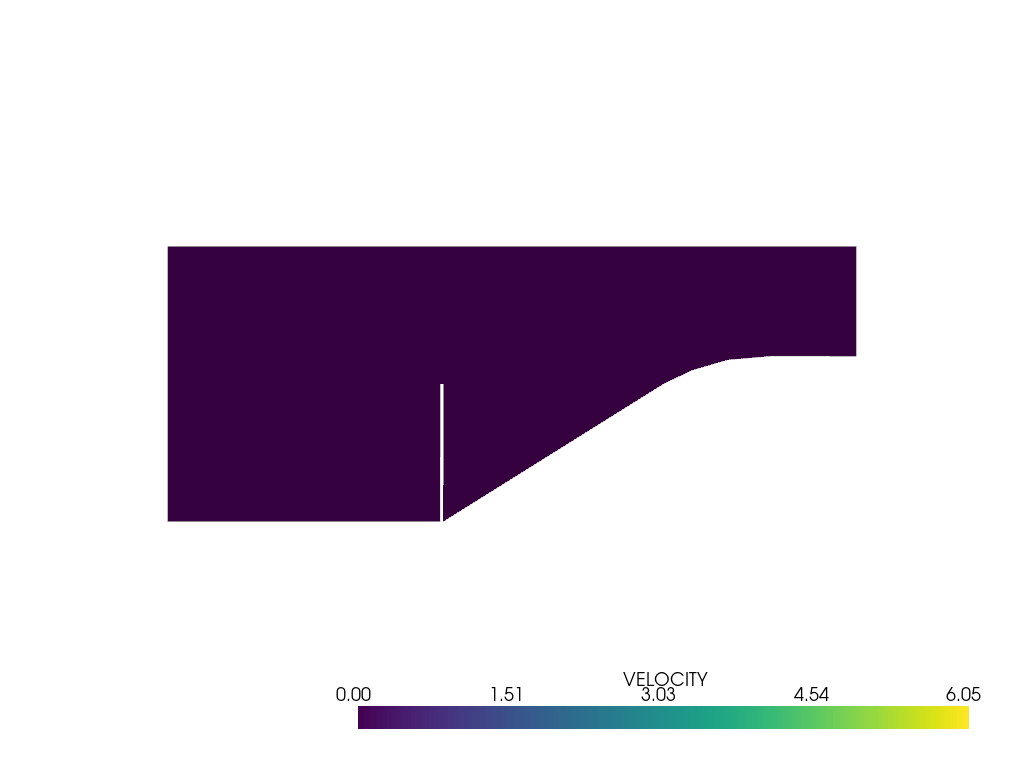

In [ ]:
Image(open('mokFSI.gif','rb').read())


## <font color='BLUE'>Optional</font>: You can load and visualize other results in the following cells

In [3]:
freq = "0.5"
fluid_res = pyvista.read("./trainingData/"+freq+"/vtk_data/vtk_output_mok_fsi_cfd/Parts_Fluid_0_100.vtk")
panel_plotter = pyvista.Plotter(notebook=True,)
panel_plotter.add_mesh(fluid_res, scalars='VELOCITY')

panel_plotter.camera_position = 'xy'
panel_plotter._on_first_render_request()

panel_plotter.update_coordinates(fluid_res.points+fluid_res.point_data["MESH_DISPLACEMENT"] , render=False)
panel.panel(
    panel_plotter.render_window, orientation_widget=panel_plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode="stretch_width")

#panel_plotter.show(jupyter_backend="static", return_viewer=True)

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='43e...], sizing_mode='stretch_width')

In [ ]:
fluid_res = pyvista.read("./trainingData/0.5/vtk_data/vtk_output_mok_fsi_cfd/Parts_Fluid_0_100.vtk")
panel_plotter = pyvista.Plotter(notebook=True, off_screen=True)
panel_plotter.add_mesh(fluid_res, scalars='VELOCITY', show_edges=False,)
panel_plotter.camera_position = 'xy'
#_ = panel_plotter.add_scalar_bar()

# Open a gif
panel_plotter.open_gif("mokFSI.gif")

pts = fluid_res.points.copy()

for i in range(1, 165):
    up_fluid_res = pyvista.read("./trainingData/0.5/vtk_data/vtk_output_mok_fsi_cfd/Parts_Fluid_0_"+str(i)+".vtk")
    up_pts = pts + up_fluid_res.point_data["MESH_DISPLACEMENT"]

    panel_plotter.update_coordinates(up_pts, render=False)
    panel_plotter.update_scalars(up_fluid_res.point_data["VELOCITY"][:, 0], render=False)

    # Write a frame. This triggers a render.
    panel_plotter.write_frame()

# Closes and finalizes movie
panel_plotter.close()

# The ROM-FOM components

As shown in the Figure above, the ROM will be consisting of 3 components/steps :


*   An encoding of the forces at the "*wet*" interface.
*   A regression model in the latent space.
*   A decoding of the full structural displacement field


---

In this workshop, you will code each component as a Python object, and these components can be taken by our Kratos version to be used for the structural ROM.

# <font color='Green'>Exercice</font> : The Forces Encoder

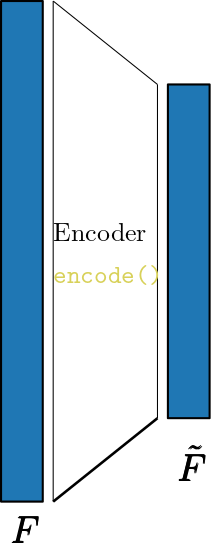

For brevity and conformity, we will use **PCA (POD) as the encoder here**.

---



**The PCA/POD method**, a brief desription:

In a nutshell, the Proper Orthogonal Decomposition (POD) relies on the assumption of a linear subspace of a lower dimension $r_f$ (ideally very small) in which the sought solution (in this case the forces field $\pmb{f}_{|\Gamma_{fsi}}$ ) lives:
\begin{equation}
\pmb{f}_{|\Gamma_{fsi}}(t) = \sum_i^{r_f} \pmb{\Phi}_{fi} \tilde{{f}}_i(t)
\end{equation}

$\pmb{\Phi}_{fi}$ are called the POD modes, and constitute the orthogonal basis for the latent space. For a snapshot matrix of forces $\pmb{F} \in \mathbb{R}^{N \times m}$, this can be written in the matrix form:
\begin{equation}
\pmb{F} = \pmb{\Phi}_f \tilde{\pmb{f}}
\end{equation}
where $\tilde{\pmb{f}} \in \mathbb{R}^{r_f \times m}$ are the coordinates of these forces in the reduced $r_f$-d subspace. For new data $\pmb{F}_{new}$, and due to orthogonality, the encoding is done through an orthogonal projection:
\begin{equation}
\tilde{\pmb{f}}_{new} = \pmb{\Phi}_f^T \pmb{F}_{new}
\end{equation}

---


**Requirements:**

1. The Python object for this component needs to be inherited from the **`RomDimensionalityReducer`** class described in details in the cell below.

You can implement the dimensionality reduction technique you think is best for this problem. We recommend using the POD method described above.

2.   For encoding the forces field `encode()` function has to be implemented.
3.   In adddition, the **`reduced_data`** property/method has to be implemented, for returning the low-dimension coordinates of the training data, that are avilable after training the model.


```python
class RomDimensionalityReducer:
    """Baseclass for dimensionality reduction used in the latent space

    """

    def __init__(self, latent_dim) -> None:
        self.latent_dim = latent_dim
        self._reduced_data = None
        self.map_mat = None
        self.interface_dim = None
        pass

    def train(self, data, map_used=None):
        """Training the dimensionality reducer

        Parameters
        ----------
        data  : numpy.ndarray
            Snapshot matrix of data, of (N, m) size
        map_used  : numpy.ndarray or None
            Snapshot matrix of mapping indices (from interface
            nodes to all the nodes), of (N, n) size.
            If None, no mapping is used
            Default : None

        Returns
        ------

        """
        assert (data.shape[0] >= self.latent_dim
                ), "Training data has to have a bigger dimension than the DimReducer latent dimension."
        self.high_dim = data.shape[0]
        pass

    def encode(self, new_data) -> np.ndarray:
        """Project the data instances to the latent space

        Parameters
        ----------
        new_data  : numpy.ndarray
            Snapshot matrix of data, of (N, m) size

        Returns
        ------
        latent_data  : numpy.ndarray
            Snapshot matrix of data, of (r, m) size

        """
        raise Exception('"encode" has to be implemented in the derived class!')

    def decode(self, new_latent_data, high_dim=False) -> np.ndarray:
        """Training the regressor

        Parameters
        ----------
        new_latent_data  : numpy.ndarray
            Snapshot matrix of data, of (r, m) size
        high_dim  : bool, optional
            Whether or not to override the mapping and returning the
            high dimensional space. Only considered when self.map_mat
            is not None
            Default : False

        Returns
        ------
        highDim_data  : numpy.ndarray
            Snapshot matrix of data,
            of (N, m) size
            or (n, m) is self.map_mat is not None

        """
        raise Exception('"decode" has to be implemented in the derived class!')


    @property
    def reduced_data(self):
        """Representations of the training data in the latent space

        Parameters
        ----------

        Returns
        ------
        reduced_data  : numpy.ndarray
            Matrix of data, of (r, m) size

        """
        if self._reduced_data is None:
            raise Exception(
                '"reduced_data" has to be implemented in the derived class!')
        else:
            return self._reduced_data


---
## <font color='Orangered'>Hint</font> :



You can use the `rom_am` package POD implementation

---

## -

In [ ]:
from rom_am.dimreducers.rom_DimensionalityReducer import *
#Other necessary imports here

class MyForceReducer(RomDimensionalityReducer):

    def __init__(self, latent_dim, ) -> None:
        super().__init__(latent_dim)


    def train(self, data,):

        super().train(data,)
        # TODO: implement training strategy
        #
        #

    def encode(self, new_data):

        # TODO: implement encoding function
        #
        #

        return encoded_


    @property
    def reduced_data(self):
        # TODO: Returning data on the reduced space
        #
        #
        return reduced_data


# <font color='ORANGE'>Solution

In [3]:
import numpy as np
from rom_am.pod import POD
from rom_am.rom import ROM
from rom_am.dimreducers.rom_DimensionalityReducer import *


class MyForceReducer(RomDimensionalityReducer):

    def __init__(self, latent_dim, ) -> None:
        super().__init__(latent_dim)

    def train(self, data, map_used=None, normalize=True, center=True):

        super().train(data, map_used)

        pod = self._call_POD_core()
        rom = ROM(pod)
        rom.decompose(X=data, normalize=normalize, center=center,
                      rank=self.latent_dim)

        self.latent_dim = pod.kept_rank
        self.normalize = normalize
        self.center = center
        self.rom = rom
        self.pod = pod

    def encode(self, new_data):

        interm = self.rom.normalize(self.rom.center(new_data))
        return self.pod.project(interm)

    def _call_POD_core(self, ):
        return POD()

    @property
    def reduced_data(self):
        return self.pod.pod_coeff


# <font color='Green'>Exercice</font> : The Displacement Decoder

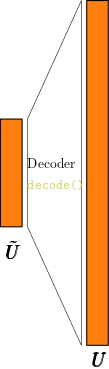

---
**Requirements**

1. The Python object for this component is also a child of the **`RomDimensionalityReducer`** class.

The same class as used in the encoder can be used here as well.
3. Instead of **`encode()`**, the **`decode()`** function has to be implemented to reconstruct the displacement field


You can implement the dimensionality reduction technique you think is best for this problem.
For brevity and conformity, we will also use POD here.

 <font color='BLUE'>Optional</font>: As an extra bonus, you can use Quadratic Manifolds [[6]](#References) as the decoder here. Explications can be found in [Appendix](#Appendix).

# <font color='Orange'>Solution

In [4]:
import numpy as np


class MyDispReducer(MyForceReducer):

      def decode(self, new_data, high_dim=False):

        interm = self.pod.inverse_project(new_data)
        return self.rom.decenter(self.rom.denormalize(interm))


# <font color='Green'>Exercice</font> : The latent regression

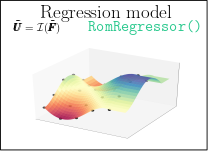

---

**Requirements**:
1. The Python object for this component needs to be inherited from the **`RomRegressor`** class described in details in the cell below.


Again, in theory you can test  the regression method you figure is best.

For conformity, we suggest using a **second degree polynomial regression with a Lasso optimization**.

```python
class RomRegressor:
    """Baseclass for regression used in the latent space

    """

    def __init__(self) -> None:
        pass

    def train(self, input_data, output_data):
        """Training the regressor

        Parameters
        ----------
        input_data  : numpy.ndarray
            Snapshot matrix of input data, of (Nin, m) size
        output_data : numpy.ndarray
            Second Snapshot matrix data, of (Nout, m) size
            output data

        Returns
        ------

        """
        assert (input_data.shape[1] == output_data.shape[1]
                ), "Training data has to have the same number of samples in input and output."
        self.input_dim = input_data.shape[0]
        self.output_dim = output_data.shape[0]
        pass

    def predict(self, new_input,) -> np.ndarray:
        """Regressor prediction

        Parameters
        ----------
        new_input  : numpy.ndarray
            New inputs matrix, of (Nin, m) size

        Returns
        ------
        output_result : numpy.ndarray
            Solution matrix data, of (Nout, m) size

        """
        raise Exception(
            '"Predict" has to be implemented in the derived class!')


---
## <font color='Orangered'>Hint</font> :



You can use the scikit-learn implementation, combining [polynomial regression](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions) and [Lasso regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

---

## -

In [ ]:
from rom_am.regressors.rom_regressor import *
#Other necessary imports here

class MyRegressor(RomRegressor):

    def __init__(self,) -> None:
        super().__init__()
        # TODO: implement additional properties
        #
        #

    def train(self, input_data, output_data):
        super().train(input_data, output_data)
        # TODO: implement training strategy
        #
        #

    def predict(self, new_input):
        # TODO: Returning predicted data
        #
        #

        return predicted_


# <font color='Orange'>Solution

In [5]:
from sklearn.linear_model import LassoLarsIC
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from rom_am.regressors.rom_regressor import *


class MyRegressor(RomRegressor):

    def __init__(self, poly_degree=2, criterion='bic', intercept_=True) -> None:
        super().__init__()
        self.criterion = criterion
        self.poly_degree = poly_degree
        self.intercept_ = intercept_

    def train(self, input_data, output_data):
        super().train(input_data, output_data)

        self.regr_model = make_pipeline(
            PolynomialFeatures(self.poly_degree, include_bias=self.intercept_), MultiOutputRegressor(LassoLarsIC(criterion=self.criterion),))
        self.regr_model.fit(input_data.T, output_data.T)

        self.nonzeroIds = []
        for i in range(self.output_dim):
            self.nonzeroIds.append(np.argwhere(np.abs(
                self.regr_model["multioutputregressor"].estimators_[i].coef_) > 1e-9)[:, 0])

    def predict(self, new_input):

        # Instead of self.regr_model.predict(new_input.T).T, the following is faster :
        self.polyFeatures = self.regr_model["polynomialfeatures"].transform(
            new_input.T)

        def mult_(proc):
            linear_ = self.polyFeatures[:, self.nonzeroIds[proc]] @ self.regr_model["multioutputregressor"].estimators_[
                proc].coef_[self.nonzeroIds[proc]].reshape((-1, 1))
            return linear_ + self.regr_model["multioutputregressor"].estimators_[proc].intercept_

        res = np.empty((self.output_dim, new_input.shape[1]))
        for i in range(self.output_dim):
            res[i, :] = mult_(i).ravel()

        return res


# Model evaluation strategy

**bold text**

# Loading training data

In [6]:
from preproc import load_data
include_subiters = True
tr_load_data, tr_disp_data, test_load_data, test_disp_data, _, _, _, _ = load_data(["0.1", "0.5", "0.9"],
                                                                                   last_incr=167,
                                                                                   last_tr_incr=87,
                                                                                   start_incr=67,
                                                                                   include_subiters=include_subiters)

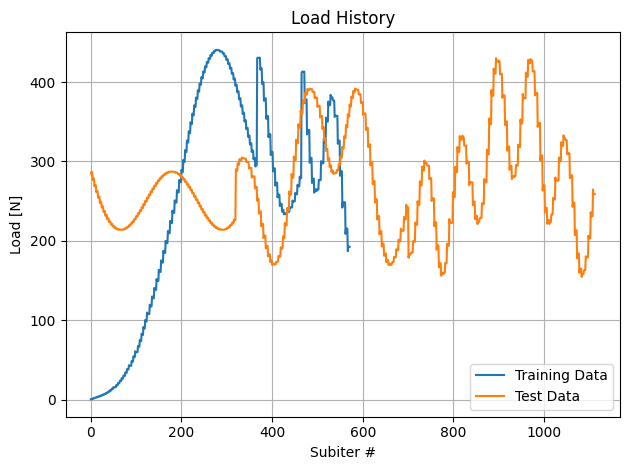

In [8]:
nodeId = 20
if include_subiters:
    plt.plot(tr_load_data[nodeId, :], label = "Training Data");
    plt.plot(test_load_data[nodeId, :], label = "Test Data");
    plt.xlabel("Subiter #");
else:

    plt.plot(tr_load_data[nodeId, :], label = "Training Data");
    plt.plot(test_load_data[nodeId, :], label = "Test Data");
    plt.xlabel("Increment #");

plt.ylabel("Load [N]");
plt.title("Load History");

plt.grid();
plt.legend();
plt.tight_layout();

We can notice the "jumps" in the solution, due to the consideration of the subiterations as well and not only the convergent solution at each time step.

# <font color='Green'>Exercice</font> : Assembling everything in a `solid_ROM()` object

In [ ]:
#disp_latentDim = ?
#force_latentDim = ?

## Using the defaults means using the already-implemented components

rom_model = solid_ROM()
rom_model.train(tr_load_data, tr_disp_data,
#                forcesReduc_model=MyForceReducer(force_latentDim),
#                regression_model=MyRegressor(),
#                dispReduc_model=MyDispReducer(disp_latentDim),
               )


# <font color='orange'>Solution

In [7]:
disp_latentDim = .9999
force_latentDim = 24

rom_model = solid_ROM()
rom_model.train(tr_load_data, tr_disp_data,
                forcesReduc_model=MyForceReducer(force_latentDim),
                regression_model=MyRegressor(),
                dispReduc_model=MyDispReducer(disp_latentDim),
               )


# Testing on offline "test"-data

We recommend this offline evaluation step to quantify the ROM accuracy. In fact, the data not used for training can be used here for evaluating the ROM and computing the relative $L_2$ error.

We suggest that this error should not exceed $2\%$ (See the cell below)

In [17]:
predicted_disp = rom_model.pred(test_load_data)

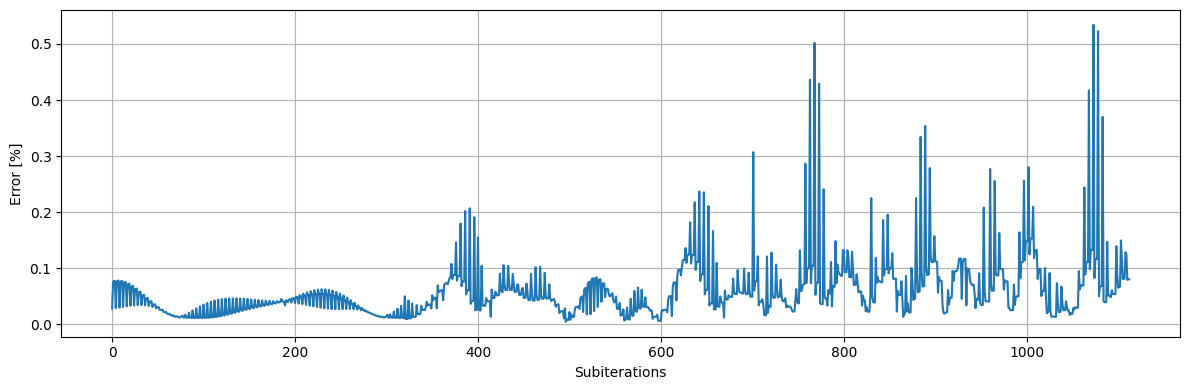

In [18]:
fig = plt.figure(figsize = (12, 4));
abs_err = np.linalg.norm(test_disp_data - predicted_disp, axis = 0)
rel_err = abs_err / np.linalg.norm(test_disp_data, axis = 0)
plt.plot(100 * rel_err,);
plt.ylabel("Error [%]");
plt.xlabel("Subiterations");
plt.tight_layout();
plt.grid();

After choosing the adequate ROM, it can be saved like the following

# Launching our ROM-FOM

In [8]:
rom_model.save("my_saved_model")

All that is left is to copy the implemented classes in **`myModels.py`** and launch the simulation:


*   The time instant when to launch the structural ROM can be modified in line 129 of **`ProjectParametersCoSim.json`**, the file name of the saved ROM in line 134.
*   The frequency $f_2$ of the inlet velocity in line 71 of **`ProjectParametersCFD.json`**.



We suggest testing for $f_2 = 1.1 Hz$

In [15]:
!python RomMainKratos.py

 |  /           |                  
 ' /   __| _` | __|  _ \   __|    
 . \  |   (   | |   (   |\__ \  
_|\_\_|  \__,_|\__|\___/ ____/
           Multi-Physics 9.4."0"-Release-9.4-6c68960-Release-x86_64
           Compiled for GNU/Linux and Python3.10 with GCC-10.2
Compiled with threading and MPI support.
Maximum number of threads: 2.
Running without MPI.
Importing    KratosCoSimulationApplication 
    KRATOS  / ___|___/ ___|(_)_ __ ___  _   _| | __ _| |_(_) ___  _ __
           | |   / _ \___ \| | '_ ` _ \| | | | |/ _` | __| |/ _ \| '_ \
           | |__| (_) |__) | | | | | | | |_| | | (_| | |_| | (_) | | | |
            \____\___/____/|_|_| |_| |_|\__,_|_|\__,_|\__|_|\___/|_| |_|
Initializing KratosCoSimulationApplication...
Importing    KratosFluidDynamicsApplication 
Initializing KratosFluidDynamicsApplication...
Importing    KratosMeshMovingApplication 
    KRATOS  __  __        _    __  __         _
           |  \/  |___ __| |_ |  \/  |_____ _(_)_ _  __ _
           | |\/| / -_|

# Results:

## Accuracy

**The tip's X-displacement response**

In [14]:
dt = 0.15
msh = pyvista.read("./testData/1.1/vtk_data/vtk_output_mok_fsi_csd/Structure_0_1.vtk")

displacement_X = np.empty((msh.points.shape[0], 167))
displacement_Y = np.empty((msh.points.shape[0], 167))
time = np.arange(0, 167)*dt
for i in range(167):
    msh = pyvista.read("./testData/1.1/vtk_data/vtk_output_mok_fsi_csd/Structure_0_"+str(i+1)+".vtk")

    displacement_X[:, i] = msh.point_data["DISPLACEMENT"][:, 0]
    displacement_Y[:, i] = msh.point_data["DISPLACEMENT"][:, 1]

displacement_X_ROM = np.empty((msh.points.shape[0], 167))
displacement_Y_ROM = np.empty((msh.points.shape[0], 167))
for i in range(167):
    msh = pyvista.read("./vtk_output_mok_fsi_csd/Structure_0_"+str(i+1)+".vtk")
    displacement_X_ROM[:, i] = msh.point_data["DISPLACEMENT"][:, 0]
    displacement_Y_ROM[:, i] = msh.point_data["DISPLACEMENT"][:, 1]


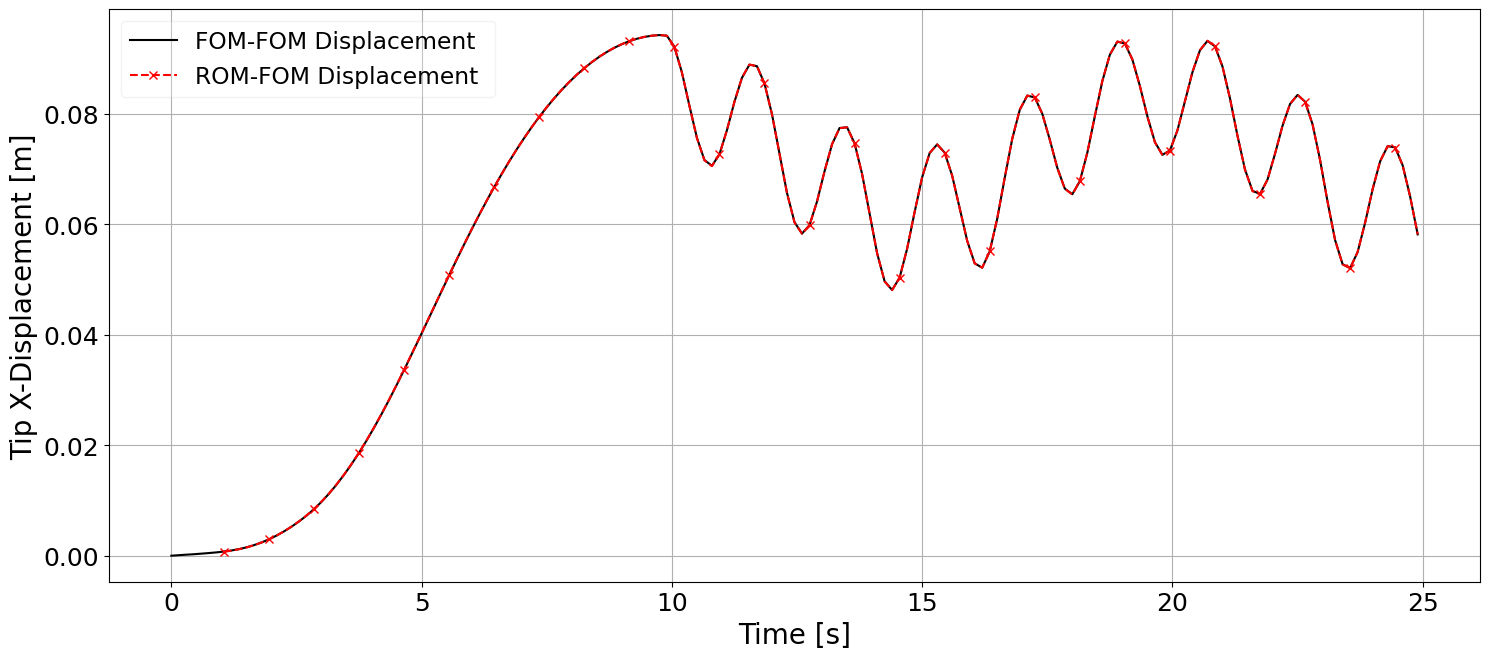

In [15]:
figure, ax = plt.subplots(figsize = (15, 6.7));
time_arr = np.arange(0, 25., 0.15);

nodeId = 1
start_pred = 7

plt.plot(time, displacement_X[nodeId, :], 'black', label = r'FOM-FOM Displacement',);
plt.plot(time[start_pred:], displacement_X_ROM[nodeId, start_pred:], 'x--',  markevery = 6, color = 'red',
         label = r'ROM-FOM Displacement ',);

ax.set_xlabel("Time [s]", fontsize = 20);
ax.set_ylabel("Tip X-Displacement [m]", fontsize = 20);

ax.tick_params(axis='both', which='major', labelsize = 18)
ax.tick_params(axis='both', which='minor', labelsize = 18)

legend = plt.legend(loc = 'best', framealpha = .25,  prop={'size': 16.8})
#frame = legend.get_frame()
#frame.set_color('white')
plt.grid();
plt.tight_layout();

## Fixed-point stability

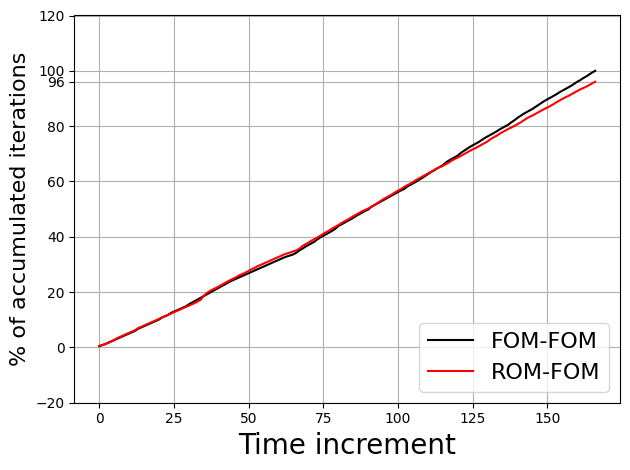

In [16]:
fig, ax = plt.subplots()
fom_iters = np.load("./testData/1.1/coSimData/iters.npy")
rom_iters = np.load("./coSimData/iters.npy")
last_ = (100*np.cumsum(rom_iters)/np.cumsum(fom_iters)[-1])[-1]

ax.plot(100*np.cumsum(fom_iters)/np.cumsum(fom_iters)[-1], color = 'k', label = 'FOM-FOM');
ax.plot(100*np.cumsum(rom_iters)/np.cumsum(fom_iters)[-1], color = 'red', label = 'ROM-FOM');
y_ticks = np.append(ax.get_yticks(), last_)
ax.set_yticks(y_ticks)

ax.set_xlabel(r"Time increment", fontsize = 20);
ax.set_ylabel(r"% of accumulated iterations", fontsize = 16);
ax.legend(fontsize = 16, loc = 'lower right',);
ax.grid();
plt.tight_layout();


## Speedups

In [25]:
fomfom_T = np.load("testData/1.1/coSimData/total_solving_time.npy")[0]
romfom_T = np.load("./coSimData/total_solving_time.npy")[0]

print("The speedup achieved is ", fomfom_T/romfom_T)


The speedup achieved is  3.0775732827212345


#  <font color='BLUE'>Optional - Extra</font>: Interface Map

An aditional property than can be used in the ROM-FOM approach, is the fact than **only the displacement at the interface is needed as an output of the structural solver**.
This can be done in a straightforward manner when using a decoder based on a reconstruction on a POD basis. If we construct a mapping matrix from the solid nodes to the interface nodes:
\begin{equation}
    \pmb{K} =  \left[
  \begin{array}{ccc}
        \rule[.5ex]{2.5ex}{0.5pt} & \pmb{\mathbb{1}}_1 &   \rule[.5ex]{2.5ex}{0.5pt}   \\
        \rule[.5ex]{2.5ex}{0.5pt} & \pmb{\mathbb{1}}_2 &   \rule[.5ex]{2.5ex}{0.5pt}   \\
        \vdots & \vdots &   \vdots   \\
        \rule[.5ex]{2.5ex}{0.5pt} & \pmb{\mathbb{1}}_N &   \rule[.5ex]{2.5ex}{0.5pt}   \\
      \end{array}     \right] \in \mathbb{R}^{N \times N_u}
\end{equation}
where $\pmb{\mathbb{1}}_i = \left[0\ldots 1 \ldots  0 \right]$ are zero row vectors with a $1$-valued element at the $j$th column where $j$ is the index of the solid mesh node corresponding to the interface node $i$.

In [16]:
map_used = np.load("./trainingData/map_used.npy")
print(map_used, "of shape", map_used.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] of shape (406, 606)


In [7]:
class MyMappedDispReducer(MyDispReducer):

  def train(self, data, map_used=None, normalize=True, center=True):
    super().train(data, map_used=map_used, normalize=normalize, center=center)

    if map_used is not None:
        self.interface_dim = map_used.shape[0]
        self.map_mat = map_used
        self.inverse_project_mat = self.map_mat @ self.rom.denormalize(
            self.pod.modes)

        if center:
            self.mapped_mean_flow = self.map_mat @ self.rom.mean_flow.reshape(
                (-1, 1))

  def decode(self, new_data, high_dim=False):

      if self.map_mat is not None and not high_dim:
          interm = self._mapped_decode(new_data)
          if self.center:
              interm = (
                  interm + self.mapped_mean_flow).reshape((-1, new_data.shape[1]))
          return interm

      else:

          interm = self.pod.inverse_project(new_data)
          return self.rom.decenter(self.rom.denormalize(interm))

  def _mapped_decode(self, new_data):
        return self.inverse_project_mat @ new_data


In [8]:
disp_latentDim = .9999
force_latentDim = 24

rom_model = solid_ROM()
rom_model.train(tr_load_data, tr_disp_data,
                forcesReduc_model=MyForceReducer(force_latentDim),
                regression_model=MyRegressor(2),
                dispReduc_model=MyMappedDispReducer(disp_latentDim),
                map_used = np.load("./trainingData/map_used.npy")
               )
rom_model.save("my_saved_model")

In [22]:

!python RomMainKratos.py


 |  /           |                  
 ' /   __| _` | __|  _ \   __|    
 . \  |   (   | |   (   |\__ \  
_|\_\_|  \__,_|\__|\___/ ____/
           Multi-Physics 9.4."0"-Release-9.4-6c68960-Release-x86_64
           Compiled for GNU/Linux and Python3.10 with GCC-10.2
Compiled with threading and MPI support.
Maximum number of threads: 2.
Running without MPI.
Importing    KratosCoSimulationApplication 
    KRATOS  / ___|___/ ___|(_)_ __ ___  _   _| | __ _| |_(_) ___  _ __
           | |   / _ \___ \| | '_ ` _ \| | | | |/ _` | __| |/ _ \| '_ \
           | |__| (_) |__) | | | | | | | |_| | | (_| | |_| | (_) | | | |
            \____\___/____/|_|_| |_| |_|\__,_|_|\__,_|\__|_|\___/|_| |_|
Initializing KratosCoSimulationApplication...
Importing    KratosFluidDynamicsApplication 
Initializing KratosFluidDynamicsApplication...
Importing    KratosMeshMovingApplication 
    KRATOS  __  __        _    __  __         _
           |  \/  |___ __| |_ |  \/  |_____ _(_)_ _  __ _
           | |\/| / -_|

# References <a name="References"></a>

[1] [D.P. Mok. Partitionierte Lösungsansätze in der Strukturdynamik und der Fluid−Struktur−Interaktion. PhD thesis: Institut für Baustatik, Universität Stuttgart, 2001.](http://dx.doi.org/10.18419/opus-147)

[2] [G. Valdés. Nonlinear Analysis of Orthotropic Membrane and Shell Structures Including Fluid-Structure Interaction. PhD thesis: Universitat Politècnica de Catalunya, 2007.](http://www.tdx.cat/handle/10803/6866)

[3] [A. Tiba, T. Dairay, F. Devuyst, I. Mortazavi, J-P. Berro Ramirez. Non-intrusive reduced order models for partitioned fluid-structure interactions. arXiv:2306.07570, 2023](https://doi.org/10.48550/arXiv.2306.07570)

[4] [R. Codina, A stabilized finite element method for generalized stationary
incompressible flows, CMAME (2001)](http://dx.doi.org/10.1016/S0045-7825(00)00260-7)

[5] [Bogaers AEJ, Kok S, Reddy BD, Franz T, Quasi-Newton
methods for implicit black-box FSI coupling. CMAME (2014)](https://doi.org/10.1016/j.cma.2014.06.033)

[6] [Geelen, S. Wright, K. Willcox, Operator inference for non-intrusive
model reduction with quadratic manifolds, CMAME (2023)](http://dx.doi.org/10.1016/j.cma.2022.115717)

## Appendix : Quadratic Manifolds <a name="Appendix"></a>

In [ ]:
import numpy as np
from rom_am.quad_man import QUAD_MAN
from rom_am.dimreducers.rom_am.podReducer import PodReducer


class MyDispReducer(PodReducer):

    def train(self, data, map_used=None, normalize=True, center=True):
        super().train(data, map_used, normalize, center)
        if map_used is not None:
            self.inverse_project_Vbar = self.map_mat @ self.rom.denormalize(
                self.pod.Vbar)

    def _call_POD_core(self):
        return QUAD_MAN()

rom_model = solid_ROM()
rom_model.train(tr_load_data, tr_disp_data,
                forcesReduc_model=MyForceReducer(force_latentDim),
                regression_model=MyRegressor(2),
                dispReduc_model=MyDispReducer(disp_latentDim),
               )
rom_model.save("my_saved_model")

We can relaunch the simulation and look at the new results:

In [ ]:
'''
!python RomMainKratos.py
'''